In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import sys
sys.path.append('../src/')
import lib

In [3]:
data_path = '../data/'

To create the pickle, 

```python
contracts = df['contractId'].unique()
agg_dict = {'contractId':'last', 'qty': ['first', 'max', 'min', 'last', 'sum', 'var'], 
            'px': ['first', 'max', 'min', 'last', 'var']}
name_arrays = [['contractId', 'qty', 'qty', 'qty', 'qty', 'qty', 'qty', 'px', 'px', 'px', 'px', 'px'],
          ['contractId', 'open', 'high', 'low', 'close', 'sum', 'var', 'open', 'high', 'low', 'close', 'var']]
name_tuples = list(zip(*name_arrays))
resampled_df = pd.DataFrame()
for i, c in enumerate(contracts):
    if i%100 == 0:
        print(i)
    temp = df[df['contractId']==c].resample('H', level=0).aggregate(agg_dict).fillna(method='ffill')
    temp_ = pd.DataFrame(index=pd.MultiIndex.from_tuples(name_tuples)).transpose()
    temp_.iloc[:,:] = temp.values
    temp_.set_index(temp.index, inplace=True)
    resampled_df = pd.concat([resampled_df, temp_])
resampled_df.to_pickle(data_path+'hourly_resampled_contracts_ohlcsv.pkl')
```

<div class="alert alert-block alert-danger">
We added some features apart from it. We could not provide the code for it now. 
</div>

In [7]:
# df = pd.read_csv(data_path+"hourly_resampled_contracts_ohlcsv_weather.csv", index_col=[0], header=[0, 1], parse_dates=True)
df = pd.read_pickle(data_path+'hourly_resampled_contracts_ohlcsv_weather.pkl')
features = ['t', 'weekday_sin', 'weekday_cos', 'run_hour', 
            'n_prev_hour_contracts', 'hour_sin', 'hour_cos', 
            'air_temp', 'rel_humidity', 'wind_speed', 'wind_dir',
            'holidays', 'qty_open', 'qty_high', 'qty_low', 'qty_close',
            'qty_var' ,'qty_sum', 'px_open','px_high', 'px_low', 'px_var']
WINDOW_SIZE = 5
forecast_df = lib.create_rolling_windows(df, WINDOW_SIZE, features, save_to_pickle=False)

After completing the feature matrix, before we move on to more complex models we will try a number of very simple baseline averages and a Lasso Regression to get a first feel for the data and what kind of results / errors we will be dealing with:

### Baseline Averages:

#### Prediction using the mean of the last five closing prices:

In [8]:
baseline_df = forecast_df.copy()
baseline_df["dummy_baseline"] = baseline_df[["t_0", "t_1", "t_2", "t_3", "t_4"]].mean(axis=1)
score = r2_score(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline"]))
maescore = mean_absolute_error(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline"]))
print("Baseline Pred. (5 price average)")
print("R2 score: ",round(score,4)*100,"%")
print("MAE score:", maescore)

Baseline Pred. (5 price average)
R2 score:  80.07 %
MAE score: 3.7769692017598993


#### Last two closing prices:

In [9]:
baseline_df["dummy_baseline2"] = baseline_df[["t_3", "t_4"]].mean(axis=1)
score2 = r2_score(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline2"]))
maescore2 = mean_absolute_error(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline2"]))
print("Baseline Pred. (2 price average)")
print("Baseline R2 score: ",round(score2,4)*100,"%")
print("Baseline MAE score:", maescore2)

Baseline Pred. (2 price average)
Baseline R2 score:  81.23 %
Baseline MAE score: 3.1512345110891617


#### Just the last price:

In [10]:
baseline_df["dummy_baseline3"] = baseline_df[["t_4"]]
score3 = r2_score(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline3"]))
maescore3 = mean_absolute_error(np.array(baseline_df["t_y"]),np.array(baseline_df["dummy_baseline3"]))
print("Baseline Pred. (last price)")
print("Baseline R2 score: ",round(score3,4)*100,"%")
print("Baseline MAE score:", maescore3)

Baseline Pred. (last price)
Baseline R2 score:  78.25999999999999 %
Baseline MAE score: 3.044569004220167


#### Exponential Smoothing, using the last three prices:

In [11]:
def ewma(data, alpha, lags):
    ewma_sum = 0
    ewma_count = 0 
    for i in range(len(data)):
        ewma_sum += ((1-alpha)**(lags-i))*data[i]
        ewma_count += (1-alpha)**(lags-i)
        ewma_fin = ewma_sum/ewma_count
    return ewma_fin

temp_df = baseline_df[["t_2","t_3", "t_4"]].copy()
alpha = 0.03
lags = 3

y_pred = []
for i in range(temp_df.shape[0]):
    temp = ewma(temp_df.loc[i], alpha, lags)
    y_pred.append(temp)

score4 = r2_score(np.array(baseline_df["t_y"]),np.array(y_pred))
maescore4 = mean_absolute_error(np.array(baseline_df["t_y"]),np.array(y_pred))
print("Baseline R2 score: ",round(score4,4)*100,"%")
print("Baseline MAE score:", maescore4)

Baseline R2 score:  81.67 %
Baseline MAE score: 3.3143130737089272


### Baseline Lasso:

In [12]:
X_train, X_valid, y_train, y_valid= lib.train_test_valid_split(forecast_df, WINDOW_SIZE, 
                                                            len(features), test_set=False)

In [15]:
# scale data
scaler_lasso = StandardScaler()
scaler_lasso.fit(X_train)
X_train_lasso = scaler_lasso.transform(X_train)
X_valid_lasso = scaler_lasso.transform(X_valid)
# initialize and fit model
elastic_model = Lasso(alpha=.2)
elastic_model.fit(X_train_lasso, y_train)
# predict and score on validation set:
result_lasso = elastic_model.predict(X_valid_lasso)
score = r2_score(y_valid,result_lasso)
msescore = mean_squared_error(y_valid,result_lasso)
maescore = mean_absolute_error(y_valid,result_lasso)
print(f"Baseline Lasso R2: {round(score,4)*100}")
print(f"Baseline Lasso MAE: {maescore}")

Baseline Lasso R2: 83.84
Baseline Lasso MAE: 3.181073021718478


#### Some early error analysis on our Lasso results: where and how can we improve?

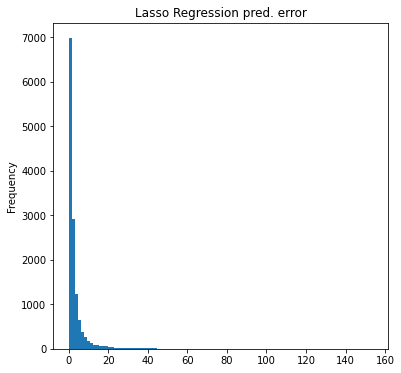

In [16]:
X_valid["preds"] = result_lasso
X_valid["true"] = y_valid
X_valid["error"] = abs(X_valid["true"]-X_valid["preds"])
ax = X_valid.error.plot(kind="hist",bins=(100), figsize=(6,6), title="Lasso Regression pred. error")

It seems the absolute size of most errors is less than 10.

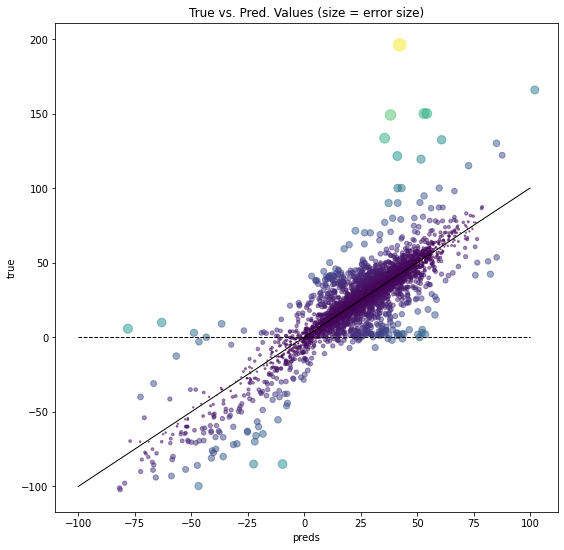

In [17]:
ax = X_valid.plot(kind="scatter", x="preds",y="true",title="True vs. Pred. Values (size = error size)",
                  s=np.array(X_valid.error), figsize=(9,9),c="error",colormap="viridis",
                  colorbar=False,alpha=.5)
ax.plot([-100, 100], [-100, 100], color='black',linewidth=1)
ax.plot([-100, 100], [0, 0], color='black', linestyle="--", linewidth=1)

There are a number of "error batches" we can see from this graph that should be considered for future models:

    - Prices with an actual value of 0-10 we are predicting to be around 15-25
    - The bottom left quadrant tells us that negative prices (also underrepresented in the data) will be predicted too optimistic
    - On the other hand, a number of prices with a true value of around 0 we are undershooting by a lot, inclidung the record error for this lasso regression
    - Overall the model is doing suprisingly well considering its simplicity